In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR, Linear, MLP
from datasets import inputs, sf_inputs_discrete
from run_td_rnn import run as run_rnn
from run_td_mlp import run as run_mlp
from run_td_linear import run as run_linear
from utils import get_firing_field, get_field_metrics
import configs

device = 'cpu'

/home/chingf/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")
/home/chingf/Code/sr-project/datasets/sf_inputs_discrete.py:19: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


# Option A: Specify dataset and run network

In [2]:
num_states = 20*20

In [3]:
gamma=0.75

In [4]:
# N-hot inputs
feature_maker_kwargs = {
    'feature_dim': num_states*2, 'feature_type': 'nhot'
    }

# Correlated inputs
feature_maker_kwargs = {
    'feature_dim': num_states, 'feature_vals': None,
    'feature_vals_p': [0.99, 0.01],
    'feature_type': 'correlated_distributed',
    'spatial_sigma': 1.75, 'gaussian_truncate': 4.0
    }

dataset_config = {
    'num_steps': 6500, 'num_states': num_states,
    'feature_maker_kwargs': feature_maker_kwargs
    }
dataset = sf_inputs_discrete.Sim2DWalk


# dataset_config = {
#     'feature_maker_kwargs': feature_maker_kwargs,
#     'num_steps': np.inf
#     }
# dataset = sf_inputs_discrete.TitmouseWalk

input_size = feature_maker_kwargs['feature_dim']
seed = 3

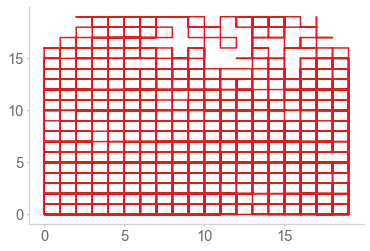

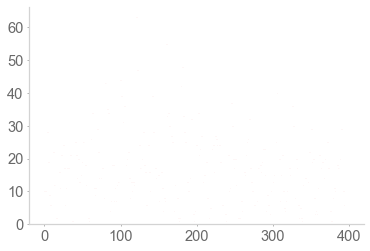

15.0


0.0275

In [5]:
input = dataset(**dataset_config)
plt.figure();
plt.plot(input.xs, input.ys)
plt.show()

plt.figure();
states = np.argwhere(input.state_inputs)[:,0]
counts = np.zeros(input.num_states)
for state in np.arange(input.num_states):
    counts[state] = np.sum(states==state)
plt.bar(np.arange(input.num_states), counts)
plt.show()
print(np.median(counts))
np.sum(counts == 0)/input.num_states

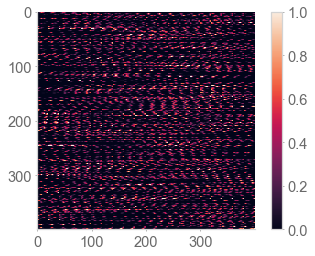

In [6]:
plt.figure()
plt.imshow(input.feature_maker.feature_map)
plt.colorbar()
plt.show()

0.09992055653186473
0.10242378968718192
False


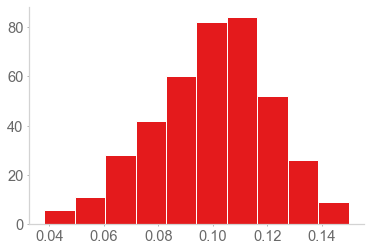

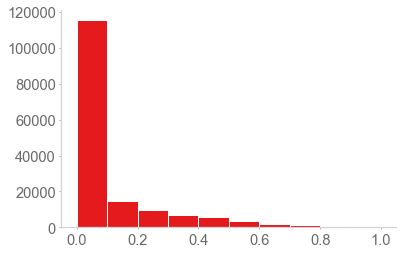

In [7]:
sparsities = []
for feat in input.feature_maker.feature_map.T:
    sparsities.append(np.sum(feat)/feat.size)
plt.hist(sparsities)
print(np.mean(sparsities))
print(np.median(sparsities))
print(0 in sparsities)

plt.figure()
plt.hist(input.feature_maker.feature_map.flatten())
plt.show()

In [8]:
arena_length = int(np.sqrt(input.num_states)) - 1
walk_xs = input.xs.astype(int)
walk_ys = input.ys.astype(int)

In [9]:
input.dg_inputs.shape

(400, 6500)

In [10]:
rnn = AnalyticSR(
    num_states=input_size, gamma=gamma,
    ca3_kwargs={
        'use_dynamic_lr':False, 'lr': 1E-3,
        #'rollout':30
        #'parameterize': True,
        'alpha': 2., 'beta': 2.
        }
    )

outputs, loss, dset = run_rnn(
    '../trained_models/test/', rnn, dataset,
    dataset_config, gamma=gamma, test_over_all=False,
    train_net=False, return_dset=True
    )


[   51] loss: 0.036
Time per step 0.045s, net 2.245s

[  101] loss: 0.029
Time per step 0.048s, net 4.627s

[  151] loss: 0.026
Time per step 0.050s, net 7.126s

[  201] loss: 0.023
Time per step 0.050s, net 9.618s

[  251] loss: 0.022
Time per step 0.052s, net 12.195s

[  301] loss: 0.020
Time per step 0.053s, net 14.859s
SVD did not converge. Small values added on diagonal.
SVD did not converge. Small values added on diagonal.

[  351] loss: 0.019
Time per step 0.052s, net 17.464s

[  401] loss: 0.018
Time per step 0.051s, net 19.995s

[  451] loss: 0.018
Time per step 0.057s, net 22.844s

[  501] loss: 0.018
Time per step 0.057s, net 25.674s
SVD did not converge. Small values added on diagonal.
SVD did not converge. Small values added on diagonal.

[  551] loss: 0.018
Time per step 0.053s, net 28.337s

[  601] loss: 0.019
Time per step 0.052s, net 30.956s

[  651] loss: 0.019
Time per step 0.059s, net 33.931s

[  701] loss: 0.020
Time per step 0.054s, net 36.650s

[  751] loss: 0.0

In [11]:
walk_xs = dset.xs
walk_ys = dset.ys
arena_length = int(np.sqrt(dset.num_states))

### Make Plots

In [12]:
from scipy import ndimage

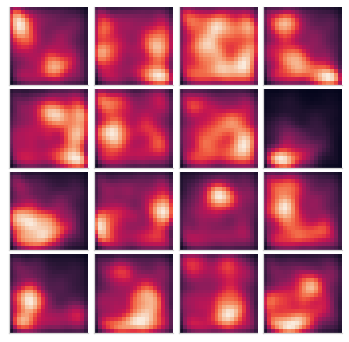

In [13]:
import matplotlib.gridspec as gridspec

grid_x = 4; grid_y = 4;

plt.figure(figsize = (6, 6))
gs1 = gridspec.GridSpec(grid_x, grid_y)
gs1.update(wspace=0.05, hspace=0.05) # set the spacing between axes. 

neurs = np.arange(outputs.shape[1])
np.random.shuffle(neurs)

idx = 0
for neur in neurs:
    ff, _ = get_firing_field(
        walk_xs, walk_ys, outputs[:,neur],
        arena_length, normalize=True
        )
    ax = plt.subplot(gs1[idx])
    plt.axis('on')
    ax.imshow(ff/ff.max(), vmin=0., vmax=1)
    ax.set_xticks([])
    ax.set_yticks([])

    idx += 1
    if idx == grid_x*grid_y: break
plt.show()

### Metrics

In [14]:
fieldsize, nfield, onefield = get_field_metrics(outputs, dset, arena_length, nshuffles=30)

In [15]:
print(f'Fieldsize: {fieldsize}')
print(f'# Fields: {nfield}')
print(f'Ratio One Field: {onefield}')

Fieldsize: 0.07931267806267807
# Fields: 1.755
Ratio One Field: 0.395


In [16]:
fieldsize, nfield, onefield = get_field_metrics(outputs, dset, arena_length, nshuffles=50)

In [17]:
print(f'Fieldsize: {fieldsize}')
print(f'# Fields: {nfield}')
print(f'Ratio One Field: {onefield}')

Fieldsize: 0.07062409812409812
# Fields: 1.7325
Ratio One Field: 0.3975


In [18]:
fieldsize, nfield, onefield = get_field_metrics(outputs, dset, arena_length, nshuffles=100)

In [19]:
print(f'Fieldsize: {fieldsize}')
print(f'# Fields: {nfield}')
print(f'Ratio One Field: {onefield}')

Fieldsize: 0.06003997093023256
# Fields: 1.72
Ratio One Field: 0.4


# Option B: Load existing results

In [15]:
results_path = '../trained_models/03_td_discrete_corr/' + \
 'sparsity0.02/sigma2.0/0.75/rnn_fixedlr_alpha/0/results.p'
with open(results_path, 'rb') as f:
    results = pickle.load(f)
if 'hopfield' in results_path:
    outputs = results['outputs'].detach().numpy().squeeze()
else:
    outputs = results['outputs']
dset = results['dset']

In [16]:
walk_xs = dset.xs
walk_ys = dset.ys
arena_length = int(np.sqrt(outputs.shape[1]))

### Make Plots

In [17]:
from scipy import ndimage

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


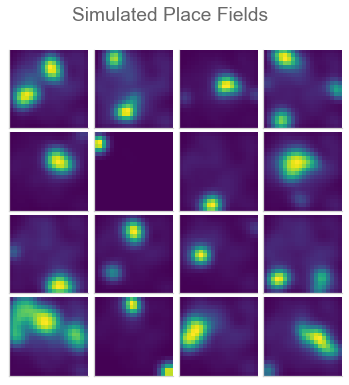

In [23]:
import matplotlib.gridspec as gridspec

grid_x = 4; grid_y = 4;

plt.figure(figsize = (6, 6))
gs1 = gridspec.GridSpec(grid_x, grid_y)
gs1.update(wspace=0.05, hspace=0.05) # set the spacing between axes. 

neurs = np.arange(outputs.shape[1])
np.random.shuffle(neurs)

idx = 0
for neur in neurs:
    ff, _ = get_firing_field(
        walk_xs, walk_ys, outputs[:,neur],
        arena_length, normalize=True
        )
    ax = plt.subplot(gs1[idx])
    plt.axis('on')
    ax.imshow(ff/ff.max(), vmin=0., vmax=1, cmap='viridis')
    ax.set_xticks([])
    ax.set_yticks([])

    idx += 1
    if idx == grid_x*grid_y: break
plt.suptitle('Simulated Place Fields')
plt.tight_layout()
plt.savefig('5c_fields', dpi=300)
plt.show()

### Metrics

In [59]:
fieldsize, nfield, onefield = get_field_metrics(outputs, dset, arena_length, nshuffles=10)

In [60]:
print(f'Fieldsize: {fieldsize}')
print(f'# Fields: {nfield}')
print(f'Ratio One Field: {onefield}')

Fieldsize: 0.05999538319482919
# Fields: 2.7075
Ratio One Field: 0.0875
